## IMPORTING REQUIRED LIBRARIES

# NAME:LAKSHMI M
# BHARAT INTERN
# PROJECT:SMS SPAM CLASSIFIER

In [1]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import re
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.utils.multiclass import unique_labels

import chardet

import warnings
warnings.filterwarnings("ignore")

In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost

In [4]:
# Importing Data

# Detect the encoding of the file
with open(r'C:\Users\laksh\OneDrive\Desktop\sms\spam.csv', 'rb') as f:
    result = chardet.detect(f.read())
    
# Read the file using the detected encoding
df = pd.read_csv(r'C:\Users\laksh\OneDrive\Desktop\sms\spam.csv', encoding=result['encoding'])
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


## EDA

In [5]:
df.shape

(5572, 5)

In [6]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [7]:
#DROPPING UNNECESSARY COLUMNS
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [8]:
df.head(5)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.duplicated().sum()

403

In [10]:
df.drop_duplicates(inplace = True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5169 non-null   object
 1   v2      5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


In [12]:
#RENAMING

df = df.rename(columns={'v1': 'label', 'v2': 'message'})
df.head(2)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [13]:
df['message_length'] = df['message'].apply(len)
df.head()

,label,message,message_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [14]:
df.describe(include='object')

,label,message
count,5169,5169
unique,2,5169
top,ham,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


In [15]:
df.groupby('label').describe().T

label                         ham        spam
message_length count  4516.000000  653.000000
               mean     70.459256  137.891271
               std      56.358207   30.137753
               min       2.000000   13.000000
               25%      34.000000  132.000000
               50%      52.000000  149.000000
               75%      90.000000  157.000000
               max     910.000000  224.000000

In [16]:
df['label'].value_counts()

ham     4516
spam     653
Name: label, dtype: int64

## DATA VISUALIZATION

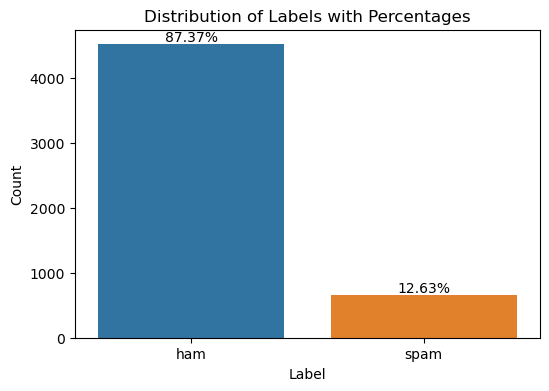

In [17]:
# Plot the value counts of 'label' with percentage inside bars
plt.figure(figsize=(6, 4))  # Adjust the figure size if needed
ax = sns.countplot(data=df, x='label')

# Calculate percentage and annotate bars with percentages
total = float(len(df['label']))
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{(height/total)*100:.2f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels with Percentages')

# Show the plot
plt.show()

## Ploting Distribution of Spam & Ham (Message Length)

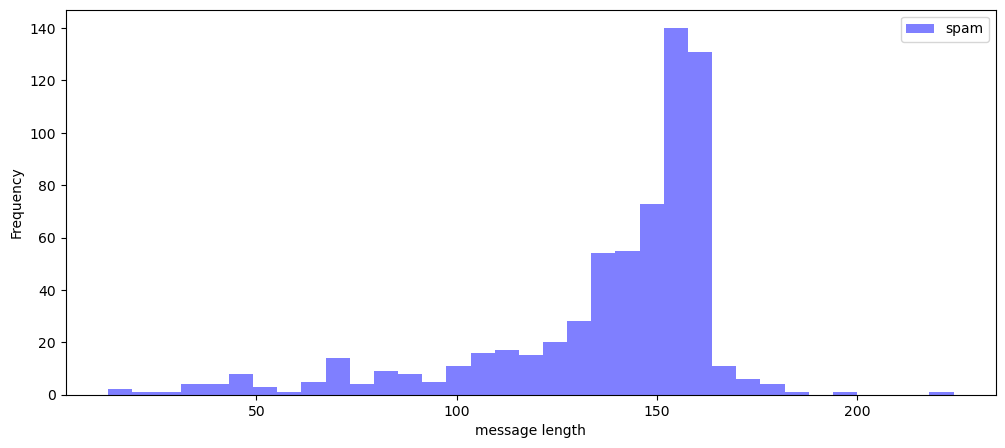

In [18]:
plt.figure(figsize=(12,5))
df[df['label']=='spam']['message_length'].plot(bins=35,kind='hist',color='blue',label='spam',alpha=0.5)
plt.legend()
plt.xlabel('message length')
plt.show()

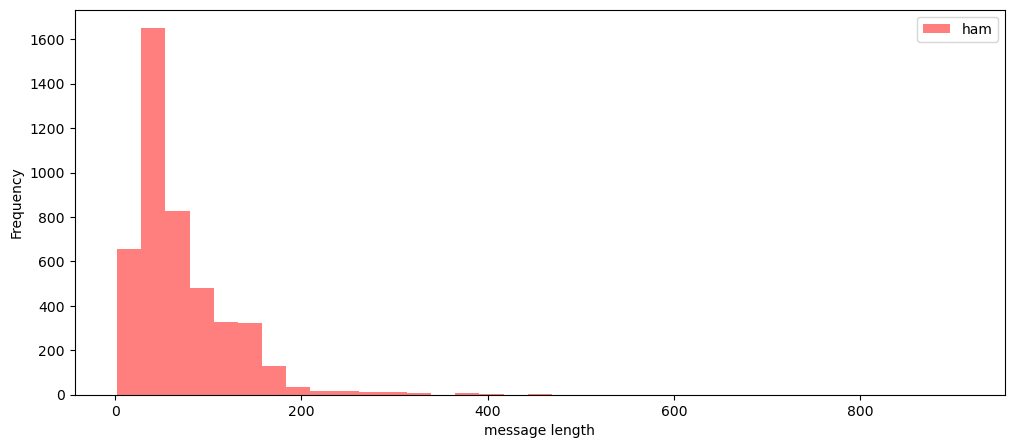

In [19]:
plt.figure(figsize=(12,5))
df[df['label']=='ham']['message_length'].plot(bins=35,kind='hist',color='red',label='ham',alpha=0.5)
plt.legend()
plt.xlabel('message length')
plt.show()

In [20]:
# Convert Labels into numerical

df.label.replace("ham",0,inplace = True)
df.label.replace("spam",1,inplace = True)

df['label'].value_counts()

0    4516
1     653
Name: label, dtype: int64

In [21]:
df_copy = df.copy()

## DATA CLEANING

In [22]:
custom_stopwords = [
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves",
    "you", "your", "yours", "yourself", "yourselves", "he", "him", "his",
    "himself", "she", "her", "hers", "herself", "it", "its", "itself",
    "they", "them", "their", "theirs", "themselves", "what", "which", "who",
    "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were",
    "be", "been", "being", "have", "has", "had", "having", "do", "does", "did",
    "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until",
    "while", "of", "at", "by", "for", "with", "about", "against", "between", "into",
    "through", "during", "before", "after", "above", "below", "to", "from", "up",
    "down", "in", "out", "on", "off", "over", "under", "again", "further", "then",
    "once", "here", "there", "when", "where", "why", "how", "all", "any", "both",
    "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not",
    "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just",
    "don", "should", "now"
]

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
def remove_stopwords_and_punctuation(text):
    punctuation = string.punctuation
    text = ' '.join([word for word in text.split() if word.lower() not in custom_stopwords and word not in punctuation])
    return text


In [27]:
import pandas as pd
import re
import string
from bs4 import BeautifulSoup

# Custom list of stopwords
custom_stopwords = [
]

def preprocess_text(text):
    punctuation = string.punctuation
    text = ' '.join([word for word in text.split() if word.lower() not in custom_stopwords and word not in punctuation])
    return text
df['clean_message'] = df['message'].apply(preprocess_text)

print(df.head(2))

   label                                            message  message_length  \
0      0  Go until jurong point, crazy.. Available only ...             111   
1      0                      Ok lar... Joking wif u oni...              29   

                                       clean_message  
0  Go until jurong point, crazy.. Available only ...  
1                      Ok lar... Joking wif u oni...  


## Word Cloud of 'Ham' & 'Spam' Messages

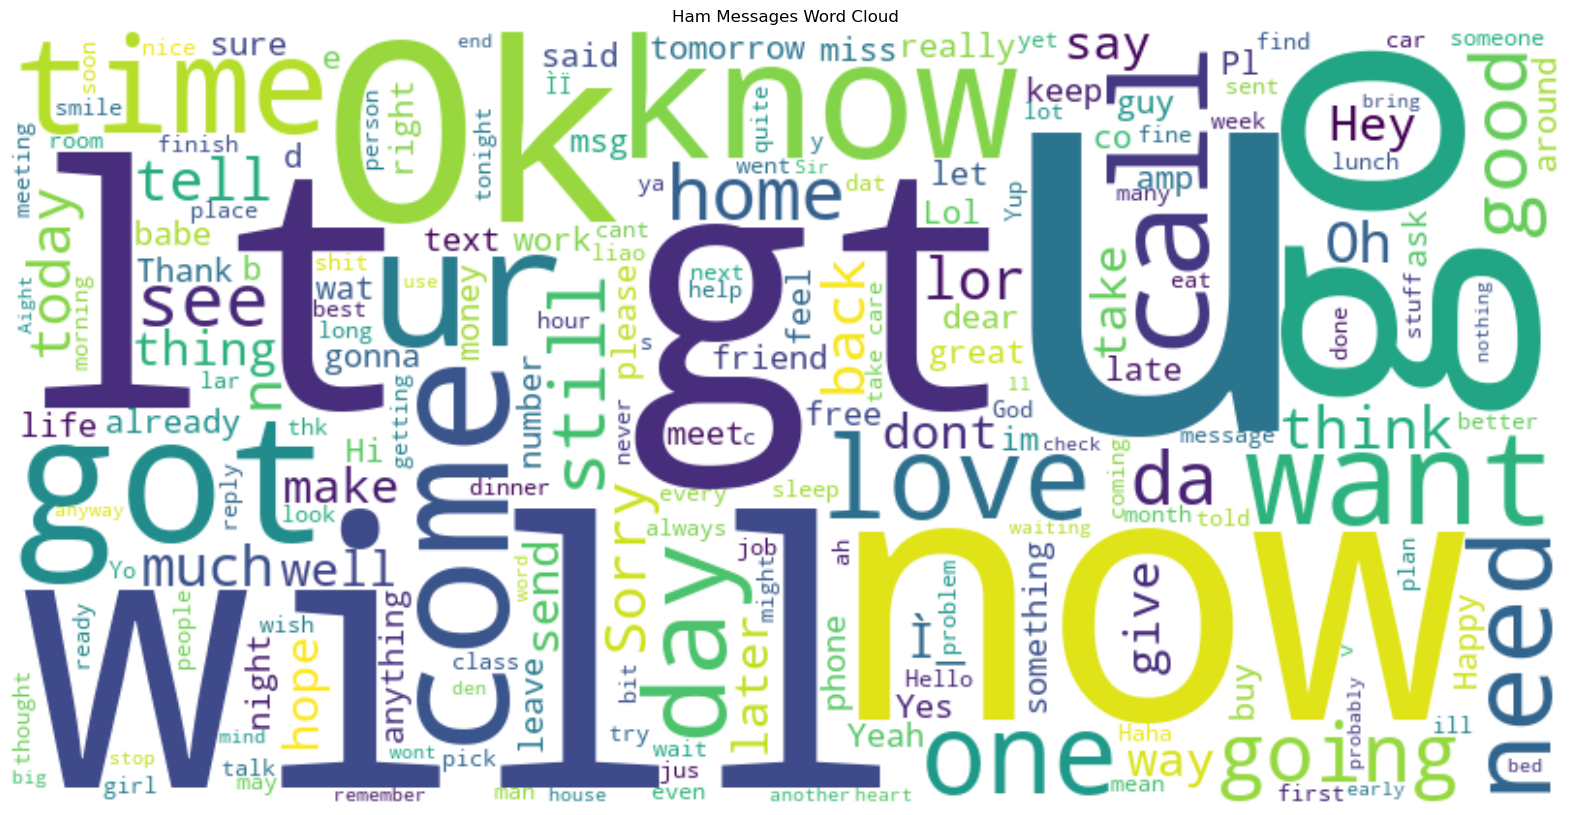

-------------------------------------------------------------------------------------------------------------------------------


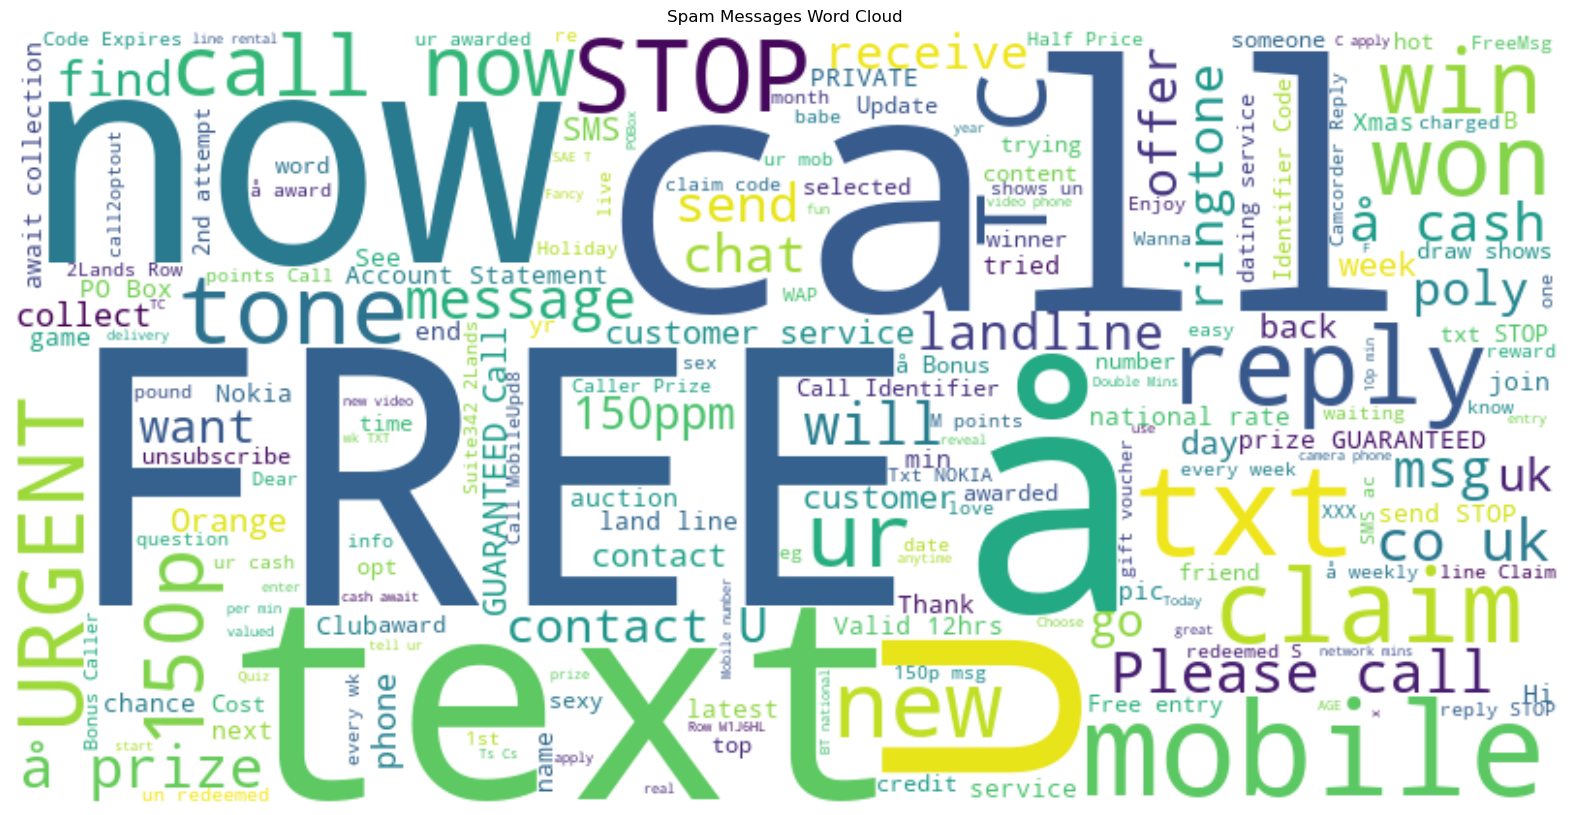

In [28]:
ham_messages = df[df['label'] == 0]['message']
spam_messages = df[df['label'] == 1]['message']

# Combine ham messages into a single string
ham_text = " ".join(ham_messages)

# Combine spam messages into a single string
spam_text = " ".join(spam_messages)

# Create word cloud for ham messages
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)

# Create word cloud for spam messages
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

# Plot the ham word cloud
plt.figure(figsize=(20, 20))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Ham Messages Word Cloud')
plt.axis('off')
plt.show()

print('-'*127)

# Plot the spam word cloud
plt.figure(figsize=(20, 20))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Spam Messages Word Cloud')
plt.axis('off')
plt.show()

In [29]:
# Add a new column 'clean_message_length'
df['clean_message_length'] = df['clean_message'].apply(len)

# Display the updated DataFrame
df

,label,message,message_length,clean_message,clean_message_length
0,0,"Go until jurong point, crazy.. Available only ...",111,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,This is the 2nd time we have tried 2 contact u...,161
5568,0,Will Ì_ b going to esplanade fr home?,37,Will Ì_ b going to esplanade fr home?,37
5569,0,"Pity, * was in mood for that. So...any other s...",57,"Pity, was in mood for that. So...any other sug...",55
5570,0,The guy did some bitching but I acted like i'd...,125,The guy did some bitching but I acted like i'd...,125


In [30]:
X = df['clean_message']
y = df['label']

## TEXT VECTORIZATION

In [31]:
# Convert text into vectors using TF-IDF

tf = TfidfVectorizer()

tfTrainReviews = tf.fit_transform(X)

tfTrainReviews

<5169x8673 sparse matrix of type '<class 'numpy.float64'>'
	with 68019 stored elements in Compressed Sparse Row format>

In [32]:
tfTrainReviews.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
# Get the feature names (words)
feature_names = tf.get_feature_names_out()

# Convert the TF-IDF matrix to a DataFrame for better visualization
tfidf_df = pd.DataFrame(tfTrainReviews.toarray(), columns=feature_names)

# Display the TF-IDF features
tfidf_df.head()

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,û_,û_thanks,ûªm,ûªt,ûªve,ûï,ûïharry,ûò,ûówell,žö
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train Test Split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(tfTrainReviews, y, test_size = 0.20, random_state = 42)

In [35]:
print("X_train shape: {}\nX_test shape: {}\nY_train shape: {}\nY_test shape: {}".format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

X_train shape: (4135, 8673)
X_test shape: (1034, 8673)
Y_train shape: (4135,)
Y_test shape: (1034,)


# MODEL BUILDING

In [36]:
# Set random state and n_jobs
random_state = 42
n_jobs = -1

# Initialize a list of classifiers with specified parameters
classifiers = [
    LogisticRegression(random_state=random_state, n_jobs=n_jobs),
    DecisionTreeClassifier(random_state=random_state),
    KNeighborsClassifier(n_jobs=n_jobs),
    MultinomialNB(),
    AdaBoostClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state, n_jobs=n_jobs),
    XGBClassifier(random_state=random_state, n_jobs=n_jobs),
    SVC(random_state=random_state)
]

results = []

# Loop through each classifier
for classifier in classifiers:
    start_time = time.time()
    
    # Train the classifier
    classifier.fit(X_train, y_train)
    
    # Predict on the training set
    y_train_pred = classifier.predict(X_train)
    
    # Predict on the test set
    y_test_pred = classifier.predict(X_test)
    
    # Calculate performance metrics for training set
    train_accuracy = np.mean(y_train_pred == y_train)
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    train_precision = train_report['weighted avg']['precision']
    train_recall = train_report['weighted avg']['recall']
    train_f1 = train_report['weighted avg']['f1-score']
    train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
    
    # Calculate performance metrics for test set
    test_accuracy = np.mean(y_test_pred == y_test)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    test_precision = test_report['weighted avg']['precision']
    test_recall = test_report['weighted avg']['recall']
    test_f1 = test_report['weighted avg']['f1-score']
    test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
    
    # Calculate the time taken for training
    build_time = time.time() - start_time
    
    # Append results to the list
    results.append([classifier.__class__.__name__, train_accuracy, train_precision, train_recall, train_f1, train_balanced_acc, 
                    test_accuracy, test_precision, test_recall, test_f1, test_balanced_acc, build_time])

# Create a DataFrame from the results
columns = ["Algorithm", 
           "Train Accuracy", "Train Precision", "Train Recall", "Train F1-score", "Train Balanced Accuracy",
           "Test Accuracy", "Test Precision", "Test Recall", "Test F1-score", "Test Balanced Accuracy",
           "Building Time (s)"]

results_df = pd.DataFrame(results, columns=columns)

# Print the results
print("Model Performance on Training and Test Sets")
results_df

Model Performance on Training and Test Sets


,Algorithm,Train Accuracy,Train Precision,Train Recall,Train F1-score,Train Balanced Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1-score,Test Balanced Accuracy,Building Time (s)
0,LogisticRegression,0.970738,0.971586,0.970738,0.969033,0.881752,0.955513,0.956198,0.955513,0.952443,0.850037,3.161333
1,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,0.965184,0.964995,0.965184,0.965082,0.924921,2.615776
2,KNeighborsClassifier,0.918501,0.925429,0.918501,0.900085,0.668307,0.899420,0.909954,0.899420,0.874080,0.641379,6.350104
3,MultinomialNB,0.961790,0.963385,0.961790,0.958679,0.844488,0.955513,0.957701,0.955513,0.951880,0.841379,0.056036
4,AdaBoostClassifier,0.982104,0.981949,0.982104,0.981736,0.939015,0.981625,0.981440,0.981625,0.981377,0.948912,8.583632
5,GradientBoostingClassifier,0.982104,0.982219,0.982104,0.981581,0.931397,0.970019,0.970156,0.970019,0.968813,0.901761,32.528656
6,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,0.975822,0.976225,0.975822,0.974935,0.916679,10.191421
7,XGBClassifier,0.996856,0.996867,0.996856,0.996839,0.987205,0.976789,0.976497,0.976789,0.976366,0.934556,3.661045
8,SVC,0.997340,0.997348,0.997340,0.997327,0.989173,0.979691,0.980159,0.979691,0.979016,0.927586,5.868564


# Build Random Forest Classifier

In [37]:
# Initialize Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train the classifier
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [38]:
# Predict on the train set
y_train_pred = random_forest_classifier.predict(X_train)

# Predict on the test set
y_test_pred = random_forest_classifier.predict(X_test)

# Calculate performance metrics for training set
train_report = classification_report(y_train, y_train_pred, output_dict=True)
train_accuracy = train_report['accuracy']
train_precision = train_report['weighted avg']['precision']
train_recall = train_report['weighted avg']['recall']
train_f1 = train_report['weighted avg']['f1-score']
train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)

# Calculate performance metrics for test set
test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_accuracy = test_report['accuracy']
test_precision = test_report['weighted avg']['precision']
test_recall = test_report['weighted avg']['recall']
test_f1 = test_report['weighted avg']['f1-score']
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Balanced Accuracy'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1, train_balanced_acc],
    'Test': [test_accuracy, test_precision, test_recall, test_f1, test_balanced_acc]
})

# Print the results DataFrame
results_df

,Metric,Train,Test
0,Accuracy,1.0,0.975822
1,Precision,1.0,0.976225
2,Recall,1.0,0.975822
3,F1-score,1.0,0.974935
4,Balanced Accuracy,1.0,0.916679


# Model evaluation

In [39]:
# Generate classification report for training data
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for Training Data:\n", train_report)

print('-'*127)

# Generate classification report for test data
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for Test Data:\n", test_report)

Classification Report for Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3627
           1       1.00      1.00      1.00       508

    accuracy                           1.00      4135
   macro avg       1.00      1.00      1.00      4135
weighted avg       1.00      1.00      1.00      4135

-------------------------------------------------------------------------------------------------------------------------------
Classification Report for Test Data:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       889
           1       0.99      0.83      0.91       145

    accuracy                           0.98      1034
   macro avg       0.98      0.92      0.95      1034
weighted avg       0.98      0.98      0.97      1034



# Confusion Matrix

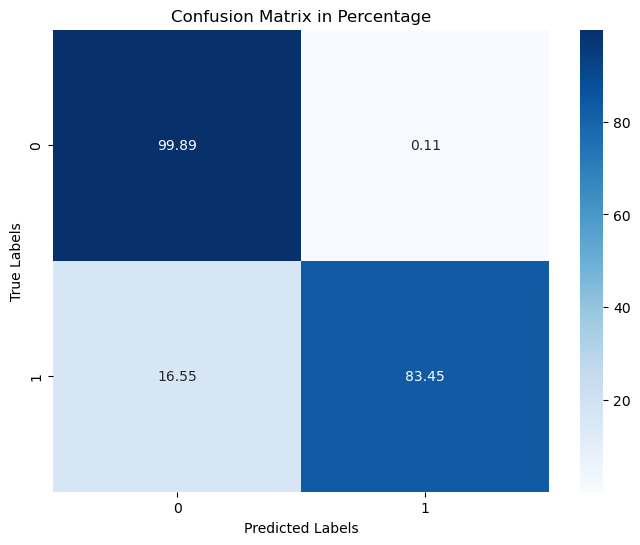

In [40]:
cm = confusion_matrix(y_test, y_test_pred)

# Calculate percentages
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

# Get class labels
class_labels = unique_labels(y_test, y_test_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix in Percentage')
plt.show()

# Cross Validation

In [41]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(random_forest_classifier, X_train, y_train, cv=5, scoring='accuracy',n_jobs=-1)

print("Cross-Validation Scores (Accuracy):", scores)
print()
print("Mean Accuracy Score:", scores.mean())

Cross-Validation Scores (Accuracy): [0.97339782 0.97097944 0.97097944 0.97097944 0.96614268]

Mean Accuracy Score: 0.9704957678355501


In [42]:
scores = cross_val_score(random_forest_classifier, X_train, y_train, cv=5, scoring='accuracy',n_jobs=-1)

print("Cross-Validation Scores (Accuracy):", scores)
print()
print("Mean Accuracy Score:", scores.mean())

Cross-Validation Scores (Accuracy): [0.97339782 0.97097944 0.97097944 0.97097944 0.96614268]

Mean Accuracy Score: 0.9704957678355501


# SAVING MODEL TO THE SYSTEM

In [43]:
import joblib

model = random_forest_classifier

joblib.dump(model, 'Ham_Vs_Spam_Classifier.pkl')

['Ham_Vs_Spam_Classifier.pkl']